In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn import tree
from sklearn import neighbors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic


from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import linear_model
from sklearn import ensemble 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

#import xgboost as xgb

#from lightgbm import LGBMRegressor
#from autosklearn.regression import AutoSklearnRegressor
#from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error

#from numba import njit
#import shap

/Users/Charlene/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
cwd = os.getcwd()

# Read and Scale the Data

In [3]:
train_data = pd.read_excel (r'data.xlsx') 

name=['Z','N','A']  #0.940609 1.02737  1.14384

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.70  # You can adjust this to set the proportion of the test set
random_state = 100  # You can choose any random_state value for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)

#test_data= pd.read_excel (r'test_fixed.xls')
#x_test = pd.DataFrame(test_data,  columns=name)  
#y_test = pd.DataFrame(test_data, columns= ['MeV'])

#test_len=len(x_test)

extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']

Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916]
Standard Deviation: [24.70939415 38.28400282 62.61852653]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]


## 3) [Gaussian Process](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)
### parameters:
### Kernel selected as RBF + White

In [4]:
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-09] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name+"\n")
            wfile.write("Scale : {} Alpha: {} Normalize: {} \n".format(str(s),str(a),str(n)))
            wfile.write("----------------------------------\n")
            ###############################
            ## Model
            ################################
            #kernel = 1.0 * Matern(length_scale=1.0, nu=2.0,length_scale_bounds=(1e-10, 1e6))+\
            #WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e4))
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

        
            ######## EY: The score is printed  ########  31/10/2023 
            score = gpr.score(x_train, y_train)
             # Print the score
            print("R^2 Score:", score)
            ###########################################  

            # Cross-validation
            #cv_scores = cross_val_score(gpr, x_train, y_train.flatten(), cv=kf, scoring='neg_mean_squared_error')
            #mean_cv_score = np.mean(cv_scores)
            #wfile.write(f'Mean Cross-Validation Score: {mean_cv_score}\n')

            # Fit the GPR model on the entire training set
            #gpr.fit(x_train, y_train.flatten())
            
            
            pred_train=gpr.predict(x_train)  #EY: Train data added
            pred_train=pred_train.reshape(-1,1)  
                
            pred=gpr.predict(x_test)
            pred=pred.reshape(-1,1)
            
            pred_extra=gpr.predict(x_extra)
            pred_extra=pred_extra.reshape(-1,1)

            ########### EY: Standart deviations are calculated  ################### 31/10/2023
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)     # Training set 
            pred_train_mean = pred_train_mean.reshape(-1, 1)  
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)               # Test set
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)       # Extrapolation set 
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)

            # Scale and normalize the standard deviations
            #sc_std = StandardScaler()
            #sc_std.fit(pred_train_std)  # Fit the scaler to the training standard deviations
            #pred_train_std_normalized = sc_std.transform(pred_train_std)
            #pred_std_normalized = sc_std.transform(pred_std)
            #pred_extra_std_normalized = sc_std.transform(pred_extra_std)
            #######################################################################  
            
            ################################
            ## Train data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_train),sc_Y.inverse_transform(y_train),sc_Y.inverse_transform(pred_train)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
    
            ################################
            ## Test data predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_test),sc_Y.inverse_transform(y_test),sc_Y.inverse_transform(pred)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            ################################
            ## Extrapolation predictions
            ################################
            data=np.concatenate((sc_X.inverse_transform(x_extra),sc_Y.inverse_transform(y_extra),sc_Y.inverse_transform(pred_extra)),axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            

            #################################  EY: The same as above but Standart deviations are also added.
            # Train Data Predictions (including standard deviations)
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std)-sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Test Data Predictions (including standard deviations)
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std)-sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            # Extrapolation Predictions (including standard deviations)
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std)-sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])

            ################################
            ## Shap Part
            ################################            
            # Fits the explainer
            #explainer = shap.Explainer(gpr.predict, x_test)
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer(x_test)
            
            #shap.summary_plot(shap_values,feature_names=name, plot_type='violin')


            #def gpr_predict(X):
             #   return gpr.predict(X).flatten()

            # Fits the explainer
            #explainer = shap.KernelExplainer(gpr_predict, shap.kmeans(x_train,4))
            # Calculates the SHAP values - It takes some time
            #shap_values = explainer.shap_values(x_test, nsamples='auto')
            
            #shap.summary_plot(shap_values, x_test, feature_names=name, plot_type='violin')
           # plt.show()
            # Create a new figure before saving to ensure the correct figure is saved
           # plt.figure()

            # Save the figure to a file (e.g., PNG)
           # plt.savefig('shap_summary_plot.pdf', dpi=600, bbox_inches='tight')
        
      
            ################################
            ## Write rms to txt file
            ################################
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write("rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n"%(rmse_train, rmse, rms_extra))
            print(rmse_train, rmse,rms_extra)
                        
            wfile.close()
            os.chdir(cwd)

R^2 Score: 0.9995548072365624
0.895660149078173 1.070580389922892 nan


### Result Explaanation
1. "R^2 Score: 0.9995548072360587" present the correlation between the predicted dependent variable and actual data. It is close to 1, which is a great result,  explaining almost all the variance of the dependent variable.
2. "0.021046297976098784 0.025156588574804902 nan" are the RMSE:
        RMSE error of training data predictions with respect to experimental data.
        Second one: RMSE error of test data predictions with respect to experimental data.
        The last one: We do not use this. It is trying to reach information in the "NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx", but in this file there is no experimental data and gives nan.

## What to do next
Steps to complete GP model:

1. Change the ratio of train and test sets. (train, test): (50, 50) (25, 75) (75, 25)
2. Change Kernels
3. Change the parameters of these Kernels to find the best result. ex: 

*length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))*

*→ change the values of 1e-4, 1e5 and 1e-10, 1e1*

## Change the ratio of train and test sets

### Code for automatically test different ratio
#### With test size = 0.4, 0.5, 0.6, 0.7, 0.8

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the train data
train_data = pd.read_excel(r'data.xlsx')

name = ['Z', 'N', 'A']  # Feature names

x_train = pd.DataFrame(train_data, columns=name)
y_train = pd.DataFrame(train_data, columns=['MeV'])

# Define different test sizes
test_sizes = [0.4, 0.5, 0.6, 0.7, 0.8]

# Load extra data
extra_data = pd.read_excel(r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data, columns=name)
y_extra = pd.DataFrame(extra_data, columns=['MeV'])

for test_size in test_sizes:
    print(f"Processing with test size: {test_size}")
    
    # Split the data into training and testing sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        x_train, y_train, test_size=test_size, random_state=100
    )
    
    train_len = len(x_train_split)
    test_len = len(x_test_split)
    
    # Concatenate the data for scaling
    inp = np.concatenate((x_train_split, x_test_split, x_extra), axis=0)
    out = np.concatenate((y_train_split, y_test_split, y_extra), axis=0)
    train_test_len = train_len + test_len

    # Initialize the StandardScaler for input data
    sc_X = StandardScaler()

    # Fit the scaler on the training data
    sc_X.fit(x_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    x_train_scaled = sc_X.transform(x_train_split)
    x_test_scaled = sc_X.transform(x_test_split)
    x_extra_scaled = sc_X.transform(x_extra)

    # Initialize the StandardScaler for output data
    sc_Y = StandardScaler()

    # Fit the scaler on the training data
    sc_Y.fit(y_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    y_train_scaled = sc_Y.transform(y_train_split)
    y_test_scaled = sc_Y.transform(y_test_split)
    y_extra_scaled = sc_Y.transform(y_extra)

    # For input data
    print("Input Data:")
    print("Mean:", sc_X.mean_)
    print("Standard Deviation:", sc_X.scale_)

    # For output data
    print("\nOutput Data:")
    print("Mean:", sc_Y.mean_)
    print("Standard Deviation:", sc_Y.scale_)

    # Concatenate original and prediction names for future use
    name_with_predictions = name + ['original', 'prediction']
    
    # Add more processing or model training here if needed


Processing with test size: 0.4
Input Data:
Mean: [ 57.57512229  80.21663173 137.79175402]
Standard Deviation: [24.43648156 37.78841425 61.82343348]

Output Data:
Mean: [-40.35911008]
Standard Deviation: [42.23861824]
Processing with test size: 0.5
Input Data:
Mean: [ 57.93545683  80.75775356 138.69321039]
Standard Deviation: [24.47976789 37.95209173 62.03254503]

Output Data:
Mean: [-39.83628956]
Standard Deviation: [42.43993737]
Processing with test size: 0.6
Input Data:
Mean: [ 57.56289308  80.25681342 137.8197065 ]
Standard Deviation: [24.59812691 38.0555712  62.25848085]

Output Data:
Mean: [-39.98845887]
Standard Deviation: [42.55248986]
Processing with test size: 0.7
Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916]
Standard Deviation: [24.70939415 38.28400282 62.61852653]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]
Processing with test size: 0.8
Input Data:
Mean: [ 56.57861635  78.68763103 135.26624738]
Standard Deviation: [24.7855499  37.963417

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Load the train data
train_data = pd.read_excel(r'data.xlsx')
name = ['Z', 'N', 'A']

x_train = pd.DataFrame(train_data, columns=name)
y_train = pd.DataFrame(train_data, columns=['MeV'])

# Load extra data
extra_data = pd.read_excel(r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data, columns=name)
y_extra = pd.DataFrame(extra_data, columns=['MeV'])

# Define different test sizes
test_sizes = [0.4, 0.5, 0.6, 0.7, 0.8]

for test_size in test_sizes:
    print(f"Processing with test size: {test_size}")
    
    # Split the data into training and testing sets
    x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
        x_train, y_train, test_size=test_size, random_state=100
    )
    
    train_len = len(x_train_split)
    test_len = len(x_test_split)
    
    # Initialize the StandardScaler for input data
    sc_X = StandardScaler()

    # Fit the scaler on the training data
    sc_X.fit(x_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    x_train_scaled = sc_X.transform(x_train_split)
    x_test_scaled = sc_X.transform(x_test_split)
    x_extra_scaled = sc_X.transform(x_extra)

    # Initialize the StandardScaler for output data
    sc_Y = StandardScaler()

    # Fit the scaler on the training data
    sc_Y.fit(y_train_split)

    # Transform the training, testing, and extra data using the fitted scaler
    y_train_scaled = sc_Y.transform(y_train_split)
    y_test_scaled = sc_Y.transform(y_test_split)
    y_extra_scaled = sc_Y.transform(y_extra)

    # Print the scaling information
    print("Input Data:")
    print("Mean:", sc_X.mean_)
    print("Standard Deviation:", sc_X.scale_)

    print("\nOutput Data:")
    print("Mean:", sc_Y.mean_)
    print("Standard Deviation:", sc_Y.scale_)

    # Model training and analysis
    os.chdir(cwd)
    analyze_name = "GP_Regression"
    if not os.path.exists(f"./{analyze_name}"):
        os.makedirs(f"./{analyze_name}")
    os.chdir(f"./{analyze_name}")
    wfile = open(f"results_{analyze_name}_selected.txt", "a")
    
    Scale = [1.0]
    Alpha = [1e-09]
    Normalize = [False]

    for s in Scale:
        for a in Alpha:
            for n in Normalize:
                wfile.write(f"{analyze_name}\n")
                wfile.write(f"Scale : {s} Alpha: {a} Normalize: {n} Test Size: {test_size}\n")
                wfile.write("----------------------------------\n")
                
                kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) + \
                         WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train_scaled, y_train_scaled)

                score = gpr.score(x_train_scaled, y_train_scaled)
                print("R^2 Score:", score)

                pred_train = gpr.predict(x_train_scaled).reshape(-1, 1)
                pred = gpr.predict(x_test_scaled).reshape(-1, 1)
                pred_extra = gpr.predict(x_extra_scaled).reshape(-1, 1)

                pred_train_mean, pred_train_std = gpr.predict(x_train_scaled, return_std=True)
                pred_mean, pred_std = gpr.predict(x_test_scaled, return_std=True)
                pred_extra_mean, pred_extra_std = gpr.predict(x_extra_scaled, return_std=True)

                data_train = np.concatenate((sc_X.inverse_transform(x_train_scaled), sc_Y.inverse_transform(y_train_scaled), sc_Y.inverse_transform(pred_train)), axis=1)
                dfw_train = pd.DataFrame(data_train)
                dfw_train.to_excel('Train_data_predictions.xlsx', index=False, header=name + ['original', 'prediction'])
                
                data_test = np.concatenate((sc_X.inverse_transform(x_test_scaled), sc_Y.inverse_transform(y_test_scaled), sc_Y.inverse_transform(pred)), axis=1)
                dfw_test = pd.DataFrame(data_test)
                dfw_test.to_excel('predictions.xlsx', index=False, header=name + ['original', 'prediction'])
                
                data_extra = np.concatenate((sc_X.inverse_transform(x_extra_scaled), sc_Y.inverse_transform(y_extra_scaled), sc_Y.inverse_transform(pred_extra)), axis=1)
                dfw_extra = pd.DataFrame(data_extra)
                dfw_extra.to_excel('extrapolation.xlsx', index=False, header=name + ['original', 'prediction'])
                
                mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train_scaled) - sc_Y.inverse_transform(pred_train))) / np.size(y_train_scaled)
                rmse_train = np.sqrt(mse_train)

                mse = np.sum(np.square(sc_Y.inverse_transform(y_test_scaled) - sc_Y.inverse_transform(pred))) / np.size(y_test_scaled)
                rmse = np.sqrt(mse)

                ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra_scaled) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra_scaled)
                rms_extra = np.sqrt(ms_extra)

                wfile.write(f"rms_train=%.4f,rms_pred=%.4f, rms_extra=%.4f\n" % (rmse_train, rmse, rms_extra))
                print(rmse_train, rmse, rms_extra)

    wfile.close()
    os.chdir(cwd)

Processing with test size: 0.4
Input Data:
Mean: [ 57.57512229  80.21663173 137.79175402]
Standard Deviation: [24.43648156 37.78841425 61.82343348]

Output Data:
Mean: [-40.35911008]
Standard Deviation: [42.23861824]
R^2 Score: 0.9995262786454809
0.9193294735965261 1.0240914197013204 nan
Processing with test size: 0.5
Input Data:
Mean: [ 57.93545683  80.75775356 138.69321039]
Standard Deviation: [24.47976789 37.95209173 62.03254503]

Output Data:
Mean: [-39.83628956]
Standard Deviation: [42.43993737]
R^2 Score: 0.9995296030171248
0.920464403598336 1.0387671565824725 nan
Processing with test size: 0.6
Input Data:
Mean: [ 57.56289308  80.25681342 137.8197065 ]
Standard Deviation: [24.59812691 38.0555712  62.25848085]

Output Data:
Mean: [-39.98845887]
Standard Deviation: [42.55248986]
R^2 Score: 0.9995421126070272
0.9105510928943559 1.0543378327837933 nan
Processing with test size: 0.7
Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916]
Standard Deviation: [24.70939415 38.28400282

## Plot of the result with different test size

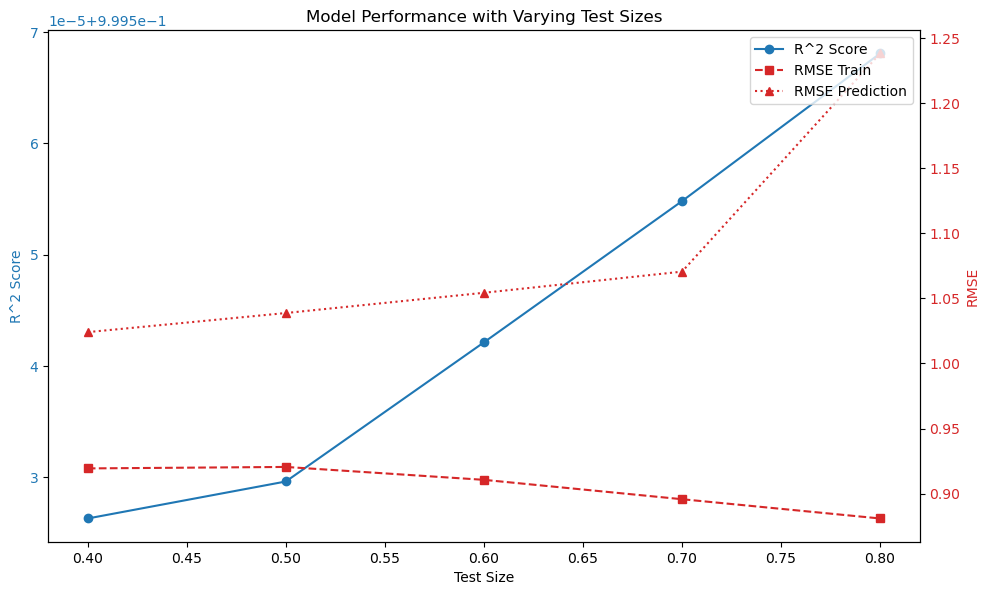

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Test Size')
ax1.set_ylabel('R^2 Score', color=color)
ax1.plot(test_sizes, r2_scores, color=color, marker='o', label='R^2 Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(test_sizes, rmse_train, color=color, marker='s', linestyle='dashed', label='RMSE Train')
ax2.plot(test_sizes, rmse_pred, color=color, marker='^', linestyle='dotted', label='RMSE Prediction')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title('Model Performance with Varying Test Sizes')
plt.show()

## Conclusion
*R² Score (blue line)* : This shows how well the model's predictions match the actual data. The values are very close to 1, indicating a high level of accuracy.

*RMSE Train (red dashed line with squares)*: This represents the error on the training dataset.

*RMSE Prediction (red dotted line with triangles)*: This represents the error on the prediction dataset.

### Discussion

1. R² Score: The R² scores are consistently very high (close to 1), indicating that the model explains almost all the variability in the target variable for different test sizes.

2. RMSE
- The RMSE values for both training and prediction increase slightly as the test size increases.
- The RMSE for the prediction set is generally higher than for the training set, which is expected as the model tends to perform better on the data it was trained on.

The plot demonstrates the Gaussian Process Regression model's performance across various test sizes ranging from 0.4 to 0.8. The R² scores remain consistently high, close to 1, indicating that the model effectively captures the variability in the target variable regardless of the test size. While the RMSE values for both training and prediction datasets show a slight increase with larger test sizes, the increase is minimal. The RMSE for the prediction dataset is consistently higher than for the training dataset, which is expected due to the model's better performance on familiar data. Overall, the model exhibits robust performance and strong generalization capabilities across different test sizes.